# Steps
1. Get mini-gridworld running
2. Create policy class with variable number of actions
3. Create a replay buffer

Loop steps 4-8:

4. Run a random policy to gather random samples, where actions are primitives + learned options
5. Create a eigenvector and learn by minimizing G
6. Determine the instantiation and termination sets
7. Instantiate a new policy with primitive actions
8. Learn with the eigenvector reward function


9. Instantiate a new policy with primitives and all learned options
10. Run experiments

In [185]:
import torch
from torch import nn
from torch import optim
from torch.distributions import Categorical
from gym_minigrid.wrappers import *
import matplotlib.pyplot as plt
import numpy as np
from einops import rearrange

%matplotlib inline

In [223]:
DEVICE = 'cuda'

def make_env(max_steps=100):
    env = gym.make('MiniGrid-FourRooms-v0')
    env.max_steps = max_steps
    env.env.max_steps = max_steps
    env = FullyObsWrapper(env) # Get pixel observations
    env = ImgObsWrapper(env) # Get rid of the 'mission' field
    return env

def render_state(env):
    img = env.render(mode='rgb_array')
    plt.imshow(img)
    plt.show()

def preprocess_obs(obs):
    obs = np.array(obs, dtype=np.float32)
    obs = obs[:, :, 0:1]
    obs /= 10.0
    obs = rearrange(obs, 'h w c -> c h w')
    return obs

def obs_to_tensor(obs):
    obs = torch.from_numpy(obs).to(DEVICE)
    if len(obs.shape) == 3:
        obs = obs.unsqueeze(0)
    elif len(obs.shape) != 4:
        raise ValueError('Invalid obs shape')
    return obs

def reset_env(env, seed=None):
    if seed is not None:
        env.seed(seed)
    return env.reset()

In [224]:
# Define a policy network
# Constructor params are the input shape and the number of actions
# Input to the model is a 2D image
class Policy(nn.Module):
    def __init__(self, n_prim_actions, options=[]):
        super().__init__()
        self.options = options
        self.n_prim_actions = n_prim_actions

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1),
            nn.ReLU())

        self.fc_layers = nn.Sequential(
            nn.Linear(32 * 11 * 11, 256),
            nn.ReLU(),
            nn.Linear(256, n_prim_actions + len(options)))

        self._init_weights()

    def _init_weights(self):
        # Init output layer weights and biases to 0
        self.fc_layers[-1].weight.data.fill_(0)
        self.fc_layers[-1].bias.data.fill_(0)
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.shape[0], -1)
        x = self.fc_layers(x)
        return x

    def sample_action(self, x):
        # Add batch dimension if not present
        if len(x.shape) == 3:
            x = x.unsqueeze(0)
            
        distribs = Categorical(logits=self.forward(x))
        actions = distribs.sample()
        for i, action in enumerate(actions):
            if action >= self.n_prim_actions:
                option_policy = self.options[action - self.n_prim_actions]
                actions[i] = option_policy.sample_action(x[i])
        return actions

# Define an eigenvector network
# Input is an observation (2D image)
# Output is a 2D matrix with the same width and height as the input
# The architecture is nearly the same as an autoencoder's
class EigenFunction(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1),
            nn.ReLU())

        self.fc_layers = nn.Sequential(
            nn.Linear(32 * 11 * 11, 128),
            nn.ReLU(),
            nn.Linear(128, 1))

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.contiguous().view(x.shape[0], -1)
        x = self.fc_layers(x)
        return x

In [225]:
class ExperienceReplay():
    def __init__(self, capacity):
        self.capacity = capacity
        self.data = []
        
    def add_step(self, step_data):
        """
        step_data: (state, action, reward, next_state, terminal)
        """
        self.data.append(step_data)
        if len(self.data) > self.capacity:
            self.data = self.data[-self.capacity:]
            
    def sample(self, n):
        n = min(n, len(self.data))
        indices = np.random.choice(range(len(self.data)), n, replace=False)
        samples = np.asarray(self.data)[indices]
        
        state_data = torch.tensor(np.stack(samples[:, 0])).float().cuda()
        act_data = torch.tensor(np.stack(samples[:, 1])).long().cuda()
        reward_data = torch.tensor(np.stack(samples[:, 2])).float().cuda()
        next_state_data = torch.tensor(np.stack(samples[:, 3])).float().cuda()
        terminal_data = torch.tensor(np.stack(samples[:, 4])).float().cuda()
        
        return state_data, act_data, reward_data, next_state_data, terminal_data

    def clear(self):
        self.data = []

In [226]:
env = make_env()

In [227]:
obs = preprocess_obs(reset_env(env))
obs = obs_to_tensor(obs)

options = [Policy(env.action_space.n).to(DEVICE)]
policy = Policy(env.action_space.n, options).to(DEVICE)

print(policy(obs))
print(policy.sample_action(torch.cat([obs] * 10, dim=0)))
print(policy.sample_action(obs))

tensor([[0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0',
       grad_fn=<AddmmBackward>)
tensor([2, 4, 1, 4, 5, 1, 2, 4, 5, 5], device='cuda:0')
tensor([2], device='cuda:0')


In [228]:
obs = preprocess_obs(reset_env(env))
obs = obs_to_tensor(obs)

eigen_function = EigenFunction().to(DEVICE)

print(obs.shape)
print(eigen_function(obs).shape)

torch.Size([1, 1, 19, 19])
torch.Size([1, 1])


In [229]:
def explore(policy, replay_buffer, n_steps=1000, env_seed=None):
    step = 0
    obs = preprocess_obs(reset_env(env, seed=env_seed))
    while step < n_steps:
        act = policy.sample_action(obs_to_tensor(obs)).item()
        next_obs, reward, done, _ = env.step(act)
        next_obs = preprocess_obs(next_obs)
        replay_buffer.add_step((obs, act, reward, next_obs, done))

        if done:
            obs = preprocess_obs(reset_env(env, seed=env_seed))
        else:
            obs = next_obs
            
        step += 1

In [307]:
def learn_eigenvector(replay_buffer, batch_size=32, n_batches=100, lagrange_mult=1):
    eigen_function = EigenFunction().to(DEVICE)
    eigen_optimizer = optim.Adam(eigen_function.parameters(), lr=1e-3)

    losses = []
    for _ in range(n_batches):
        ### Loss Part 1 ###

        # Sample state transitions from history
        obs, _, _, next_obs, _ = replay_buffer.sample(batch_size)

        # Calculate values of eigenvector in samples states
        eigen_features = eigen_function(obs)
        next_eigen_features = eigen_function(next_obs)

        distance_losses = torch.square(eigen_features - next_eigen_features)

        
        ### Loss Part 2 ###

        # Sample state transitions from history
        obs, _, _, _, _ = replay_buffer.sample(batch_size)
        _, _, _, next_obs, _ = replay_buffer.sample(batch_size)

        # Calculate values of eigenvector in samples states
        eigen_features = eigen_function(obs)
        next_eigen_features = eigen_function(next_obs)

        repulsion_losses = \
            (torch.square(eigen_features) - 1) * \
            (torch.square(next_eigen_features) - 1) + \
            torch.square(eigen_features) * \
            torch.square(next_eigen_features)

        total_losses = 0.5 * distance_losses + lagrange_mult * repulsion_losses
        loss = torch.mean(total_losses)
        losses.append(loss.item())

        eigen_optimizer.zero_grad()
        loss.backward()
        eigen_optimizer.step()

    return eigen_function, losses

def render_eigenvector(eigen_function, env, env_seed):
    agent_indicator = np.array([10, 0, 1], dtype=np.uint8)
    empty_indicator = np.array([1, 0, 0], dtype=np.uint8)

    ev_map = np.zeros((19, 19), dtype=np.float32)
    obs = reset_env(env, env_seed)
    agent_pos = env.unwrapped.agent_pos
    obs[agent_pos[0], agent_pos[1]] = empty_indicator
    for i in range(19):
        for j in range(19):
            if (obs[i, j] == empty_indicator).all():
                obs[i, j] = agent_indicator
                tensor_obs = obs_to_tensor(preprocess_obs(obs))
                ev_map[i, j] = eigen_function(tensor_obs).item()
                obs[i, j] = empty_indicator
    ev_map = ev_map.T

    # Normalize the non-zero values of ev_map for plotting
    non_zero_indices = np.nonzero(ev_map)
    non_zero_indices = np.stack(non_zero_indices)
    non_zero_elements = ev_map[non_zero_indices[0], non_zero_indices[1]]
    min_val = non_zero_elements.min()
    max_val = non_zero_elements.max()
    ev_map[non_zero_indices[0], non_zero_indices[1]] = \
        (non_zero_elements - min_val) / (max_val - min_val)

    # Flip the map if necessary to make the more explored states lighter colored
    if ev_map[agent_pos[0], agent_pos[1]] < 0.5:
        ev_map[non_zero_indices[0], non_zero_indices[1]] = \
            1 - ev_map[non_zero_indices[0], non_zero_indices[1]]

    plt.imshow(ev_map)

In [308]:
explore_steps = 10000
ev_batch_size = 32
ev_batches = 50
lagrange_mult = 1
env_seed = 0

replay_buffer = ExperienceReplay(capacity=100000)

# Start loop

# Explore and gather samples
replay_buffer.clear()
exploration_policy = Policy(env.action_space.n).to(DEVICE)
explore(exploration_policy, replay_buffer, explore_steps, env_seed)

# Learn the eigenvector
eigen_function, losses = learn_eigenvector(replay_buffer,
    ev_batch_size, ev_batches, lagrange_mult)


<ipython-input-225-95dbd8d46284>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  samples = np.asarray(self.data)[indices]


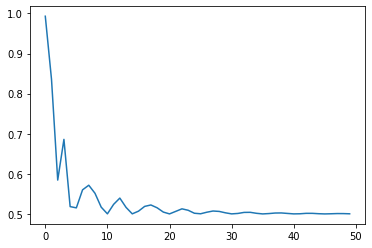

In [309]:
plt.plot(losses)

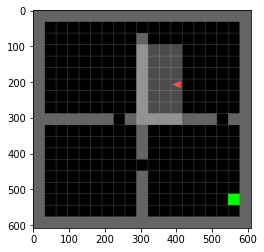

In [310]:
reset_env(env, seed=env_seed)
render_state(env)

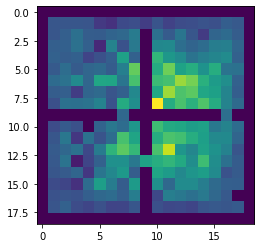

In [311]:
render_eigenvector(eigen_function, env, env_seed)